In [1]:
import os
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman')
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.integrate import odeint
from model_aug_koopman import Aug_Koopman_Model, Multi_INT_net, Aug_Koopman_ModelQP, get_initial_condition
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import pickle
file_name_results = 'QP_Sinus_HankelEDMD'
output_file_folder = '/homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/' + file_name_results +'/'
try:
    os.makedirs(output_file_folder)    
    print("Directory " , output_file_folder ,  " Created ")
except FileExistsError:
    print("Directory " , output_file_folder ,  " already exists, overwriting results")  

Directory  /homes/s17ouala/Bureau/Sanssauvegarde/Complement/Koopman reduction/LearningKoopman/Identification/Models_And_Outputs/QP_Sinus_HankelEDMD/  already exists, overwriting results


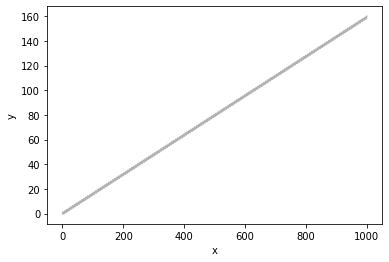

In [2]:
np.random.seed(42)
dim = 1
true_t = np.linspace(0, 1000, 10000+1)
true_y = true_t/(2*np.pi) + np.sin(true_t)
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
# In[]
# data
dt   = true_t[1]-true_t[0]
S_train = true_y[:500].reshape(1,-1,1)
S_test  = true_y[500:].reshape(1,-1,1)
T_train = true_t[:500].reshape(1,-1,1)
T_test  = true_t[500:].reshape(1,-1,1)
Batch_size = S_train.shape[1]
X_train = S_train[0,:,:]
X_test  = S_test[:,:,:]
nb_Batch   = int(X_train.shape[0]/Batch_size)
X_train = torch.from_numpy(X_train.reshape(nb_Batch,Batch_size,dim)).double()
T_train = torch.from_numpy(T_train.reshape(nb_Batch,Batch_size,dim)).double()
batch_size_test = 500#X_test.shape[1]
nb_batch_test   = int(X_test.shape[1]/batch_size_test)
X_test  = torch.from_numpy(X_test[:,:-1,:].reshape(nb_batch_test,batch_size_test,-1)).double()
T_test  = torch.from_numpy(T_test[:,:-1,:].reshape(nb_batch_test,batch_size_test,-1)).double()

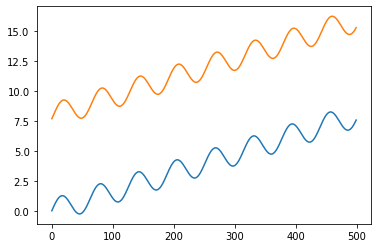

In [3]:
plt.plot(X_train[0,:,0])
plt.plot(X_test[0,:500,0])

In [4]:
params = {}
params['length_embed'] = 100
params['delay_embed']  = 1

In [5]:
H = X_train.T[:,params['delay_embed']:-(params['length_embed']*params['delay_embed'])+params['delay_embed']]
for i in range(2,params['length_embed']):
    H = np.concatenate((H,X_train.T[:,i*params['delay_embed']:-(params['length_embed']*params['delay_embed'])+i*params['delay_embed']]))
H = np.concatenate((H,X_train.T[:,params['length_embed']*params['delay_embed']:]))
svd = TruncatedSVD(n_components=16, n_iter=7, random_state=42)
v = svd.fit_transform(H[:,:,0].T)
Train_X_EDMD = v[:-1,:]
Train_Y_EDMD = v[1:,:]
A_EDMD  = np.dot(np.linalg.pinv(Train_X_EDMD[:,:]),Train_Y_EDMD[:,:]).T

In [6]:
HT = X_test.reshape(-1,1).T[:,params['delay_embed']:-(params['length_embed']*params['delay_embed'])+params['delay_embed']]
for i in range(2,params['length_embed']):
    HT = np.concatenate((HT,X_test.reshape(-1,1).T[:,i*params['delay_embed']:-(params['length_embed']*params['delay_embed'])+i*params['delay_embed']]))
HT = np.concatenate((HT,X_test.reshape(-1,1).T[:,params['length_embed']*params['delay_embed']:]))

In [7]:
pred_EDMD = np.zeros((X_test.shape[1]+100000,Train_Y_EDMD.shape[-1]))# np.zeros_like(X_test)
v_init = svd.transform(HT.T)
pred_EDMD[:1,:] = v_init[:1,:]#Train_Y_EDMD[-1:,:]# 
for i in range(X_test.shape[1]+100000-1):
    pred_EDMD[i+1,:] = np.dot(A_EDMD,pred_EDMD[i,:].T).T
pred_EDMD_VDP = svd.inverse_transform(pred_EDMD)

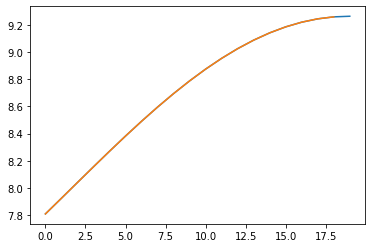

In [8]:
plt.plot(pred_EDMD_VDP[:20,0])
plt.plot(X_test[0,1:20,0])

In [9]:
out_res = {}
out_res['train_data'] = X_train
out_res['test_data'] = X_test#[3:,-1:]#[43:,:][:3000]
out_res['dt']  =dt
out_res['infered_test']  =pred_EDMD_VDP[:,:1]#[43:,:][:3000]

In [10]:
pickle_out = open(output_file_folder+file_name_results+".pkl","wb")
pickle.dump(out_res, pickle_out)
pickle_out.close()

In [11]:
file_to_read = open(output_file_folder+file_name_results+".pkl", "rb")
res = pickle.load(file_to_read)

In [12]:
def R_C_E(y_true, y_pred): 
    return (np.sum((y_true - (y_pred))**2)/ np.sum(y_true**2)) *100
test_batch = res['test_data'].data.numpy()#[idx][:,:]
pred_batch = res['infered_test'][:500,:]#[idx][:res['test_data'][idx].shape[0],:2]
# In[]
R_C_E(test_batch[0,1:,0],pred_batch[:500-1,0])

1.592011959026971e-24

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


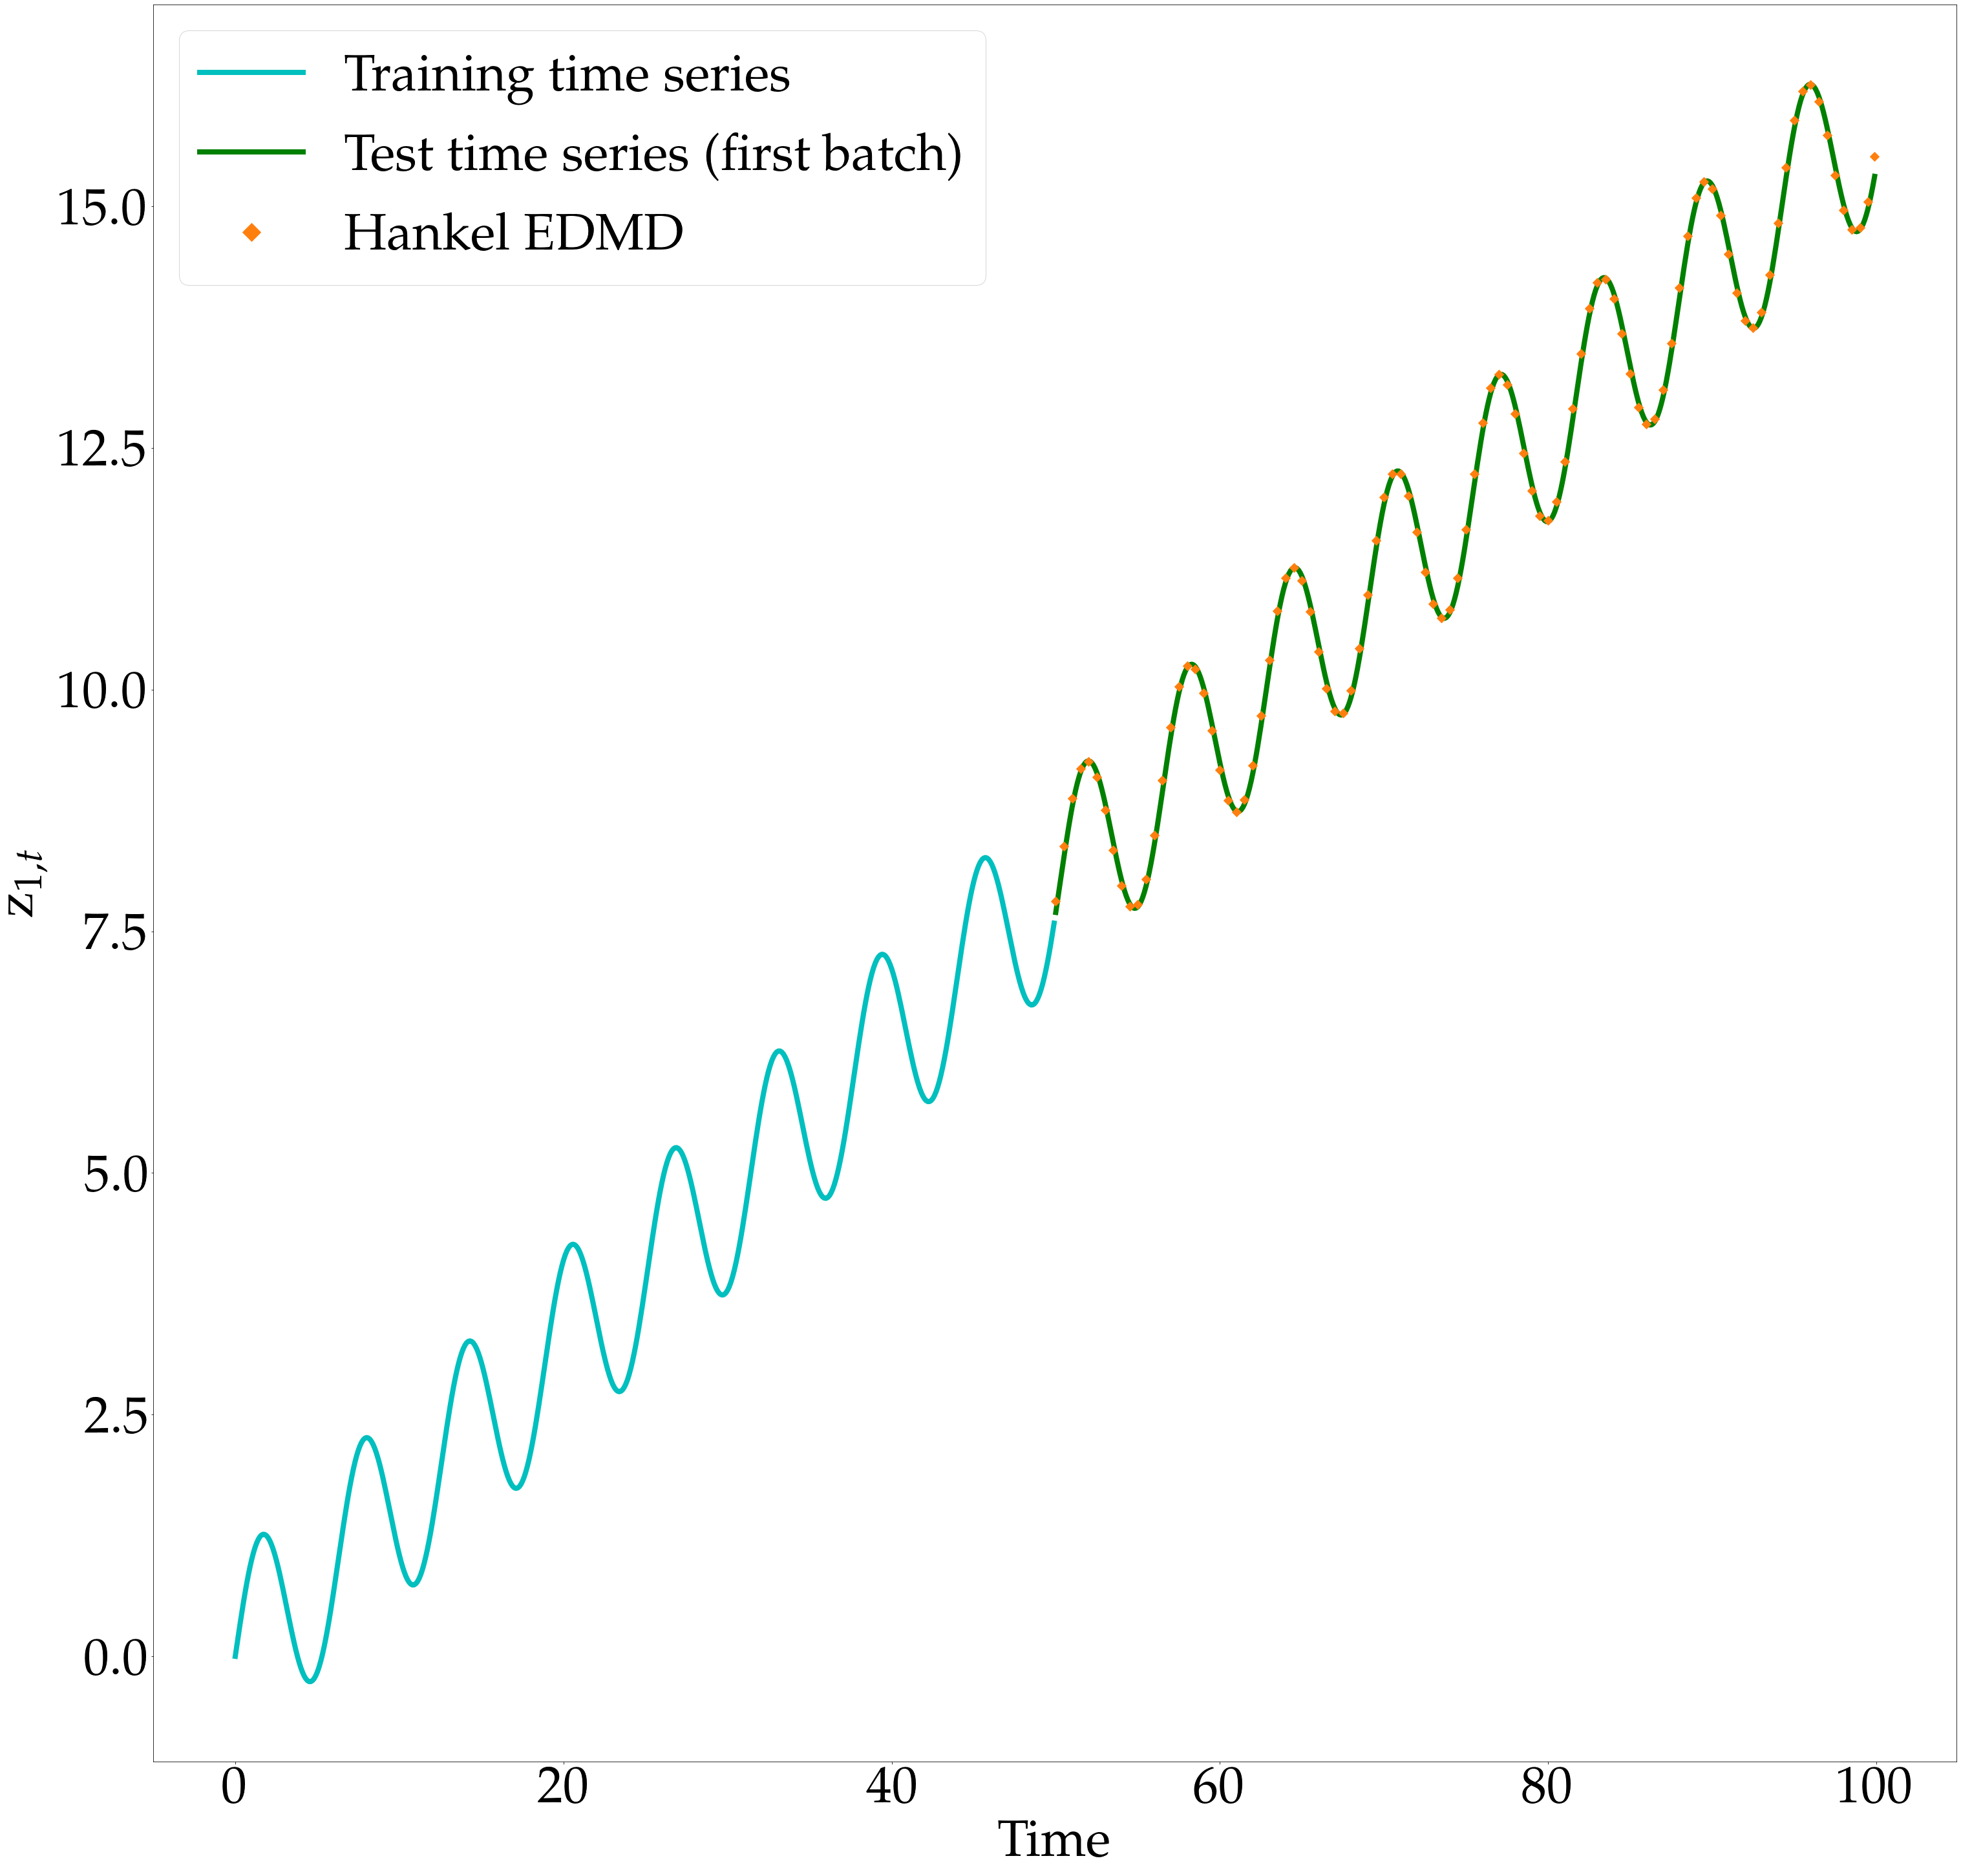

In [13]:
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 80})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig=plt.figure(figsize=(50,50))

train_series     = np.zeros((500*2,1))*np.nan
test_series      = np.zeros((500*2,1))*np.nan
predicted_series = np.zeros((500*2,1))*np.nan

train_series[:500,:]     = res['train_data'][:,:]
test_series[500:,:]      = res['test_data'][0,:,:]
predicted_series[500:,:][::5] = res['infered_test'][:500,:1][::5]
predicted_series[-1,:] = res['infered_test'][500,:1]
plt.plot(np.linspace(0,1000*0.1-0.1,1000),train_series,lw = 8,c = 'c',label = 'Training time series')
plt.plot(np.linspace(0,1000*0.1-0.1,1000),test_series,lw = 8,c = 'g',label = 'Test time series (first batch)')
plt.plot(np.linspace(0,1000*0.1-0.1,1000),predicted_series,"D",c = 'tab:orange',markersize=10,label = 'Hankel EDMD')

plt.xlabel('Time')
plt.ylabel('${\mathrm{z}}_{1,t}$')
plt.legend(markerscale=2)